# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 10 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

### Exercise 10.2

Apply your code to the TSP problem for 50 american state-capitals longitude and latitude coordinates in the *American_capitals.dat* file.

Do you improve with respect using one single Continent?

Do you improve with respect using (up to) 10 independent Continents?

# Theory

We want to apply parallelization to the Genetic Algorithm (GA) already developed in the previous lecture. Here we parallelize our code not to improve the execution time, but rather to perform a more accurate search of the best path in the space of all possible solutions to the TSP problem. The idea is to execute the GA search with N different cores, every core will execute a process where the random generator has a differnt seed respect the others processes. In this way we obtain N statistical indipendent GA searches, that we wish to put in communication with each other, to share information (the respective best chromosomes) in order to have a more ergdic search.

We try to do this using a message passing model of parallelization. The framework of this model consists in having separate cores with their separate address space, buffer, and bus, all connected to a central network. We then can send and receive data among the different adress spaces. To implement this message passing model of parallelization we use the MPI standard.

Among all MPI operations accesible the most relevant for our implementation of the code are the send and receive operations which allows to exchange data among different cores. There are both blocking  and non blocking send and receive operations, and we must be careful how we use these to avoid deadlocks. Deadlocks for example can arise if two blocking send are called by both cores, and both wait for a receive call which can't occure. To avoid this we should pair every send call with a receive call that we expected to call in parallel time. (As explained for example here https://stackoverflow.com/questions/20448283/deadlock-with-mpi). The solution we will use to avoid possible deadlocks consists in mixing blocking and non blocking send calls.

given

1) a Population pop 

2) the number of generations to sample, N_generations

3) the list of chromosome we wish to switch among different continents, vec_exchange

4) two indexes for the cores among which there is the exchange, index1 and index2

The structure of the code we implement is the following 
(We work in the singe program multiple data framework, so the cores execute all the same program, so we have to imagine the N cores to run the program simultaneously)


    for i in range(N_generations)
        get new generation from pop
        for j in vec_exchange
               if(rank==0)
                   select randomly the first core, index1
                   select randomly the second core, index2!=index1
               broadcast index1 from 0 to all the the other cores
               broadcast index2 from 0 to all the the other cores
               
               if(rank==index1)
               non blocking send(chromosome number j) //here chromosome j is in index1 address space 
               blocking receive(chromosome number j )
               if(rank==index2)
               blocking send(chromosome number j ) //here chromosmoe j is in index2 addres space
               blocking receive(chromomsome number j )
                 

# Results

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
matplotlib.rcParams['figure.figsize'] = [6, 6] # for square canvas

## Variation of the number of cores

As a first case we check if and how the parallelization with different numbers of cores helps in finding a better solution to the TSP problem for the fifty capitals of the USA. 
We run the program with a number of cores from 1 to 8, and keep the minimum distance found among all the different continents, for every run.


In [2]:
def plot_data(ax, x, y, string) :
    ax.plot(x, y, label="Parallelized")#, 
    ax.set_xlabel('N cores')
    ax.set_ylabel("Minimum distance")
    ax.set_title(f"TSP parallelization for {string}")
    ax.legend()
    ax.grid(True)
                  
def plot_kfact(ax, x, y, string) :
    ax.plot(x, y, label="Parallelized")#, 
    ax.set_xlabel('N cores')
    ax.set_ylabel("(1core-Ncore)/Ncore")
    ax.set_title(f"TSP parallelization for {string}")
    ax.legend()
    ax.grid(True)                  

In [3]:
path="DATA/"
fname="fit_varying_ncores_USA.txt"
file_kf="kfact_USA.txt"

In [4]:
cores , distance =np.loadtxt(path + fname, unpack=True)
cores , kfact=np.loadtxt(path + file_kf, unpack=True)
Ncities=50

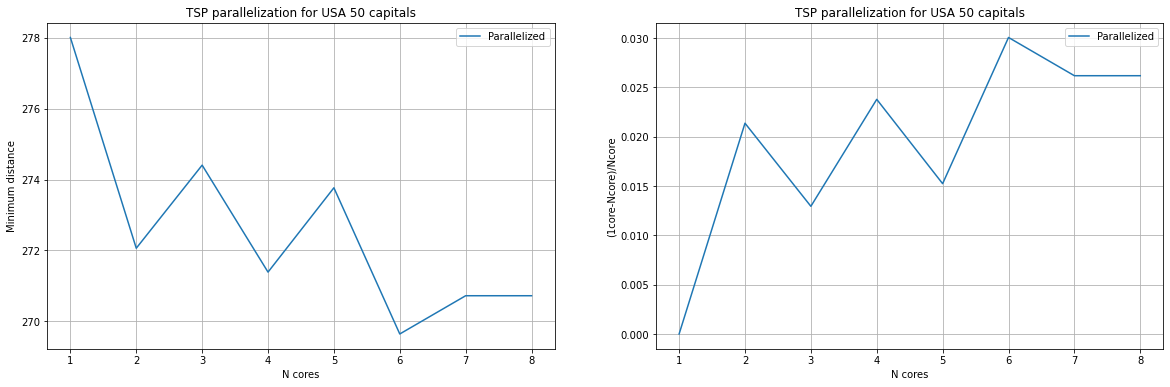

In [6]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))

plot_data(ax1, cores, distance, "USA 50 capitals")
plot_kfact(ax2, cores, kfact, "USA 50 capitals"  )

We can see a decrease in the minimum distance. Though with just this data it is hard to understand if the deacresing behaviour is obtained thanks to the exchange of information among continents, or rather because of effects related to the seed. What we mean is that, runs with different random generators are statistically indepenedent and so can lead to a different best path. At every run we add one more core and so one more simulation of the GA algorithm with a different random generator, so there is a chance that, with this new statistical indipendent run, we are finding a new minimum just by means of the chance that a differnt random seed will give a new minimum. So we can't tell that a decreasing behaviour is actually related to a non trivial parallelization of communicating runs, since the variation of the minimum distance is of the order of the variation found when changing the seed of the generator. 

To try understand if this is what actually happens we try to plot a parallelized run vs a trivially parallelized run (i.e. with no communacation, in which then every decrease of the minimum distance is due to the presence of a new process with a new seed).

It is possible that parallelization becomes more relevant with increasing the number of cities N, since for a low N our implementation of the genetic algorithm could be ergodic enough by itself, even without the help of parallelization. So we can try to work with 50 cities and more, on a square of side 1. Though we must limit the number of cities choosen to the values for which the GA algorithm is able to find a good solution, that is one with no crossings. So we will work with a max of 65/70 cities.

In [7]:
path="DATA/"
fname="fit_varying_ncores_50_Standard.txt"
file_kf="kfact_50.txt"
file_nonpar="fit_varying_ncores_50_Standard_nonpar.txt"

In [8]:
cores , distance =np.loadtxt(path + fname, unpack=True)
cores , nonpar=np.loadtxt(path + file_nonpar, unpack=True)
cores , kfact=np.loadtxt(path + file_kf, unpack=True)

Ncities=50

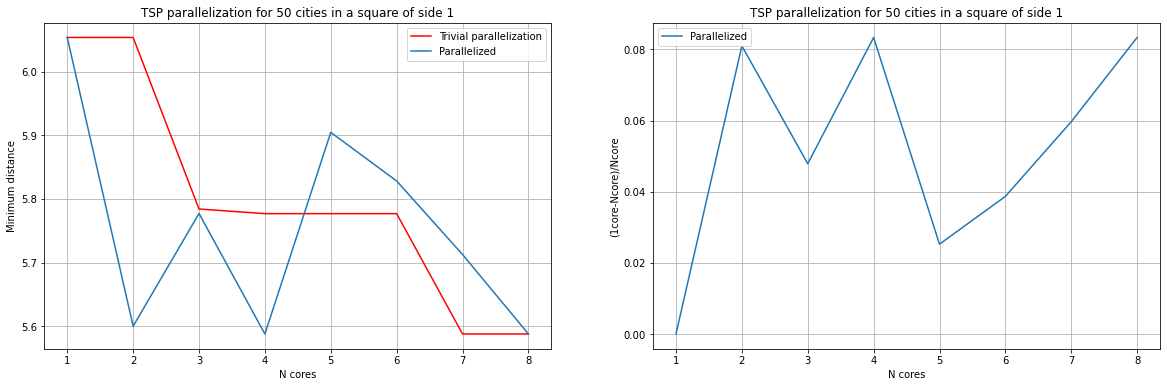

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(cores, nonpar, color="r", label="Trivial parallelization")
plot_data(ax1, cores, distance, "50 cities in a square of side 1")

plot_kfact(ax2, cores, kfact, "50 cities in a square of side 1")

In [10]:
path="DATA/"
fname="fit_varying_ncores_55_Standard.txt"
file_kf="kfact_55.txt"
file_nonpar="fit_varying_ncores_55_Standard_nonpar.txt"

In [11]:
cores , distance =np.loadtxt(path + fname, unpack=True)
cores , nonpar=np.loadtxt(path + file_nonpar, unpack=True)
cores , kfact=np.loadtxt(path + file_kf, unpack=True)
Ncities=55

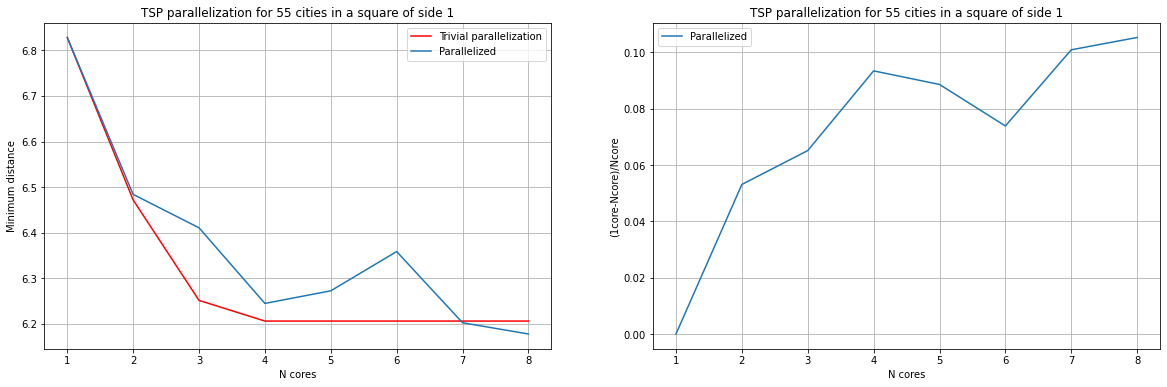

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(cores, nonpar, color="r", label="Trivial parallelization")
plot_data(ax1, cores, distance, "55 cities in a square of side 1")
plot_kfact(ax2, cores, kfact, "55 cities in a square of side 1")

In [13]:
path="DATA/"
fname="fit_varying_ncores_60_Standard.txt"
file_kf="kfact_60.txt"
file_nonpar="fit_varying_ncores_60_Standard_nonpar.txt"

In [14]:
cores , distance =np.loadtxt(path + fname, unpack=True)
cores , nonpar=np.loadtxt(path + file_nonpar, unpack=True)
cores , kfact=np.loadtxt(path + file_kf, unpack=True)
Ncities=200

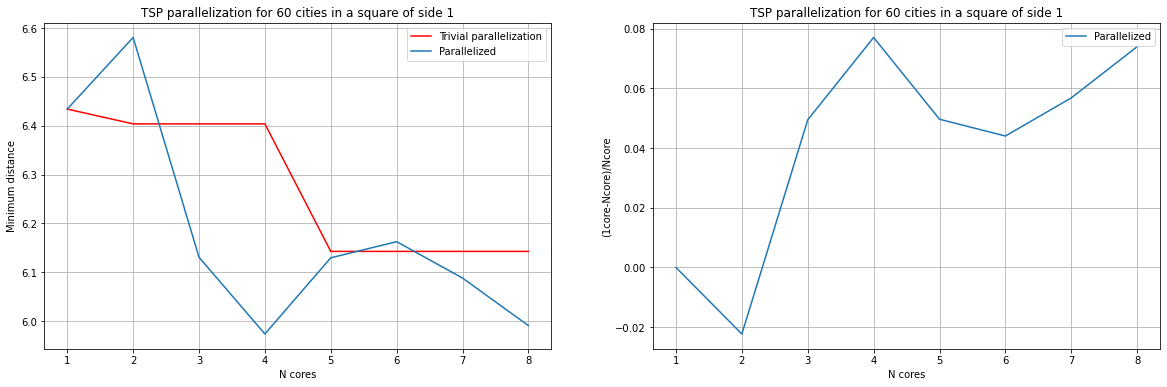

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(cores, nonpar, color="r", label="Trivial parallelization")
plot_data(ax1, cores, distance, "60 cities in a square of side 1")
plot_kfact(ax2, cores, kfact, "60 cities in a square of side 1")

In [16]:
path="DATA/"
fname="fit_varying_ncores_65_Standard.txt"
file_kf="kfact_65.txt"
file_nonpar="fit_varying_ncores_65_Standard_nonpar.txt"

In [17]:
cores , distance =np.loadtxt(path + fname, unpack=True)
cores , nonpar=np.loadtxt(path + file_nonpar, unpack=True)
cores , kfact=np.loadtxt(path + file_kf, unpack=True)
Ncities=500

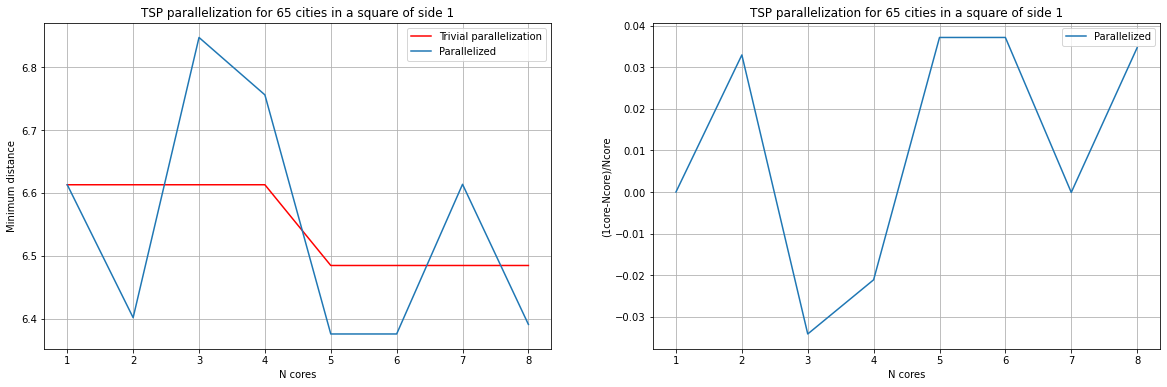

In [18]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(cores, nonpar, color="r", label="Trivial parallelization")
plot_data(ax1, cores, distance, "65 cities in a square of side 1")
plot_kfact(ax2, cores, kfact, "65 cities in a square of side 1")

In [19]:
path="DATA/"
fname="fit_varying_ncores_70_Standard.txt"
file_kf="kfact_70.txt"
file_nonpar="fit_varying_ncores_70_Standard_nonpar.txt"

In [20]:
cores , distance =np.loadtxt(path + fname, unpack=True)
cores , nonpar=np.loadtxt(path + file_nonpar, unpack=True)
cores , kfact=np.loadtxt(path + file_kf, unpack=True)
Ncities=1000

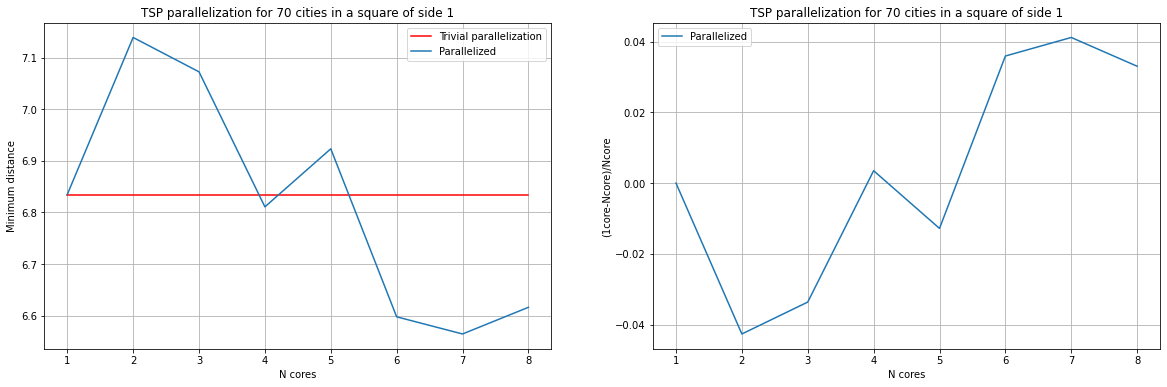

In [21]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(cores, nonpar, color="r", label="Trivial parallelization")
plot_data(ax1, cores, distance, "70 cities in a square of side 1")
plot_kfact(ax2, cores, kfact, "70 cities in a square of side 1")

These were the results from 50 to up to 70 cities in a square of side 1. Before discussing the plots, we should emphasize one thing. In general we expect that the parallelization can do no harm. Maybe it doesn't help in finding a best solution, but it shoudln't give a worse result than the one trivially parallelized. This seems right and in contradiction to some of the plots above. To me the point is that the communication in the parallelization does no harm only on average, i.e. taking in considerations only a stastics. For a single run with a particular seed, the exchanging of chromosomes leads to different stocastic processes which therefore can ends with differnt results. So a confrontation of the results for the minimum among the red and blue line for a single point (i.e e a process with N core) isn't that usefull, since a change of the seed would disrupt that result. What is more important in these plots to me is to compare the general behaviour while increasing the number of cores. 

It seems to me that even though in some cases the trend of the parallelized and trivially parallelized plots is slightly different (in favor of the relevance of parallelization) there is overall a similar behaviour. So this tell us that the decrease in the minimum distance si mainly due to the increasing of the statistics with a partial contribution of parallelization. 

To notice a greater relevance for the parallelization maybe are neccesary more than 8 cores, or simply our GA works good enough for TSP with these order of cities' number. It should be reasonable to think that with a higher number of cities the situation is much more complicated and a GA can get stuck on certain local minima more easily, and there the parallelization may be more relevant to increase the erogodicity of the algorithm.

In [22]:
path="DATA/"
fname1="kfact_50.txt"
fname2="kfact_55.txt"
fname3="kfact_60.txt"
fname4="kfact_65.txt"
fname5="kfact_70.txt"

In [23]:
cores , kfact1=np.loadtxt(path + fname1, unpack=True)
cores , kfact2=np.loadtxt(path + fname2, unpack=True)
cores , kfact3=np.loadtxt(path + fname3, unpack=True)
cores , kfact4=np.loadtxt(path + fname4, unpack=True)
cores , kfact5=np.loadtxt(path + fname5, unpack=True)

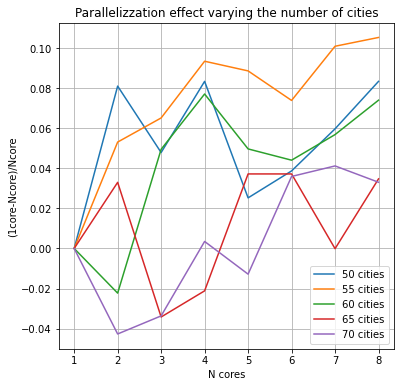

In [24]:
plt.plot(cores, kfact1, label="50 cities") 
plt.plot(cores, kfact2, label="55 cities") 
plt.plot(cores, kfact3, label="60 cities") 
plt.plot(cores, kfact4, label="65 cities")
plt.plot(cores, kfact5, label="70 cities") 
plt.xlabel('N cores')
plt.ylabel("(1core-Ncore)/Ncore")
plt.title(f"Parallelizzation effect varying the number of cities")
plt.legend()
plt.grid(True)

These plot shows the discrepancy between the minimum distance found with one core and N cores (weighted by the value of the minimum distance at Ncores), while having a non trivial parallelization.

# Varying cities' number with 8 cores fixed

Now we try to do an analysis of the parallelization relevance for the GA performance that uses a statiscs of runs. This way we should avoid the porblems discussed above in understanding if the decreasing of the minimum distance is really consequence of the parallelization. The number of cores will be fixed to 8.

We work with different numbers of cities, from 10 to 100, inside a square of side 1. And perform 10 runs at every fixed number of cities to obatin our statistics. We confront the results obtained with a non trivial parallelization and no parallelization. Results are obtained both selection operators of the GA. As a reference we plot even the numerical and theoretical bounds of lecture 9.

In [33]:
City_vec=np.linspace(10, 100, 10, int)
Nsim=10;
L=1
select=2# 1 or 2, to choose selection operator

the following chell was used to prepare the input files

In [34]:
City_vec=np.linspace(10, 100, 10, int)
Nsim=10;
L=1

if(select==1) :
    method="SA"
elif(select==2) :
    method="Standard"
    
#https://numpy.org/doc/stable/reference/random/generator.html
rng = np.random.default_rng(12345)

with open('input_8cores_' + method + '.dat', 'w') as f:

    print("#flag for parallelization-", "row1-", "row2-", "NCities-", "slection operator index-", file=f)
    for i in City_vec :
        for j in range(Nsim) :
            print(1, rng.integers(1,30000) ,rng.integers(1,30000), int(i), select, file=f) 
            #1 for non trivial paralleziation
            #rng. ... for cities random generator,
            #i for number of cities

In [35]:
PATH1="DATA/"
PATH2="DATA/Lezione_9_data/"
nonpar_standard=PATH2+"bound_fixedL_Standard.txt"
nonpar_sa=PATH2+"bound_fixedL_SA.txt"
par_standard=PATH1+"fit_8cores_Standard.txt"
par_sa=PATH1+"fit_8cores_SA.txt"

In [36]:
def get_values_nonpar(filename) :
    output=np.loadtxt(filename)
    values=[output[i*Nsim:(i+1)*Nsim] for i in range(Nsim)]#minimum distance value of each run
    averages=[np.mean(values[i]) for i in range(Nsim)]
    errors=[(np.var(values[i])/Nsim)**(0.5) for i in range(Nsim)]
    return averages, errors

def get_values_par(filename) :
    trash, output=np.loadtxt(filename, unpack=True)
    values=[output[i*Nsim:(i+1)*Nsim] for i in range(Nsim)]#minimum distance value of each run
    averages=[np.mean(values[i]) for i in range(Nsim)]
    errors=[(np.var(values[i])/Nsim)**(0.5) for i in range(Nsim)]
    return averages, errors

In [37]:
av1, err1 = get_values_nonpar(nonpar_standard)
av2, err2 = get_values_nonpar(nonpar_sa)
av3, err3 = get_values_par(par_standard)
av4, err4 = get_values_par(par_sa)

In [38]:
exp_bounds=[0.7078*n**(0.5)+0.551 for n in City_vec]
teo_bounds=[(5/8+19/5184.)*n**(0.5) for n in City_vec]

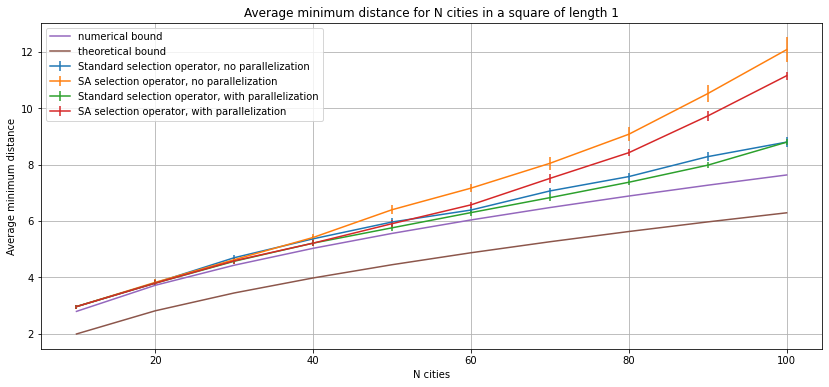

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.errorbar(City_vec, av1, yerr=err1 , label="Standard selection operator, no parallelization")
ax.errorbar(City_vec, av2, yerr=err2 , label="SA selection operator, no parallelization")
ax.errorbar(City_vec, av3, yerr=err3 , label="Standard selection operator, with parallelization")
ax.errorbar(City_vec, av4, yerr=err4 , label="SA selection operator, with parallelization")
ax.plot(City_vec, exp_bounds, label="numerical bound")
ax.plot(City_vec, teo_bounds, label="theoretical bound")
ax.set_xlabel("N cities")
ax.set_ylabel("Average minimum distance")
ax.set_title(f"Average minimum distance for N cities in a square of length 1")
ax.legend()
ax.grid()

Here in general we can see how the parallelized GA performs better, for both selection operators. In both cases infact the parallelized curves stands lower respect the case with no parallelization.